In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import torchvision.transforms as T
from torchvision import models
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from __future__ import print_function

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models

import copy

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 224

# Instance Segmentation

In [0]:
# Load the pre-trained models: The pre-trained models have been trained on a subset of COCO train2017, 
# on the 20 categories that are present in the Pascal VOC dataset.

# Fully Convolutional Network ResNet - 2014: https://arxiv.org/abs/1411.4038
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()
# DeepLabV3 ResNet - 2017: https://arxiv.org/abs/1706.05587
deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

In [0]:
# Function to convert 2D image to a RGB image
def decode_segmap(image, nc=21):
  """
    image - matrix/2D image where each value is a integer between 0-20 to denote one of the 21 classes
    nc - number of classes in the model transfered

    returns - 
  """
  # The models transfered inherit 21 classes from Pascal VOC dataset
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  # Three channels of new matrix
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  # For each class, we assign the color chosen to a new matrix of size "image" that will act as a mask
  for l in range(0, nc):
    idx = image == l # Matrix of size "image" with True or False
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [0]:
def segment(net, path, show_orig=True, dev='cuda'):
  """
    net - model used to predict on data
    path - directory to read the image
  """
  img = Image.open(path)
  
  if show_orig: 
    plt.imshow(img)
    plt.axis('off')
    plt.show()
  
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([#T.Resize(imsize), 
                   #T.CenterCrop(imsize), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  
  inp = trf(img).unsqueeze(0).to(dev) # Tensor 
  out = net.to(dev)(inp)['out'] # Tensor
  # om: 2D image (1 channel where each value corresponds to class)
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy() 
  rgb = decode_segmap(om)

  plt.imshow(rgb)
  plt.axis('off')
  plt.show()

  return img, inp, out, om, rgb

In [0]:
# !wget -nv "https://i.pinimg.com/originals/fc/21/c5/fc21c58d160419fa2d4af81b952051f0.jpg" -O test.jpg
content_path = "/content/drive/My Drive/DeepLearningX/sample/chingyu_yo.jpg"

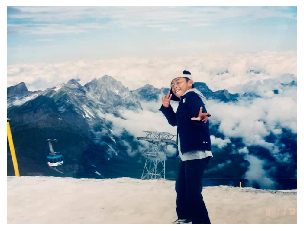

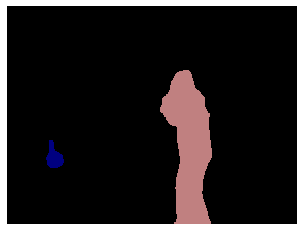

In [8]:
img, inp, out, om, rgb = segment(deeplab, path=content_path, show_orig=True, dev = device)

Merging both images

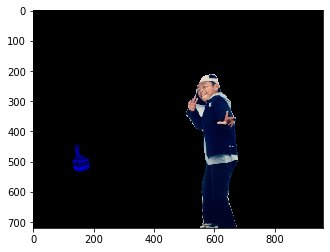

In [9]:
img_ = np.array(img)
img_[rgb == 0] = 256
plt.imshow(img_)

# Neural Style Transfer

In [0]:
# desired size of the output image
loader = T.Compose([T.Resize(imsize),  # scale imported image
                    T.CenterCrop(imsize),
                    T.ToTensor()])  # transform it into a torch tensor

# This function turns images from 0-255 into 0-1, which is the way PyTorch Tensor interprets images
def image_loader(image_name):
  """
    image_name - path of the image
    returns - tensor of the image of size (batch_size, image size)
  """
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0) # fake batch dimension required to fit network's input dimensions
    return image.to(device, torch.float)

In [0]:
unloader = T.ToPILImage()  # reconvert into PIL image

plt.ion()

# If image in PyTorch tensor format with values from 0-1, 
# we have to convert back into PIL format 0-255 to plot it
def imshow(tensor, output_path, title=None):
  """
    tensor - image loaded using image_loader function
  """
  image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
  image = image.squeeze(0)      # remove the fake batch dimension
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
      plt.title(title)
  #plt.savefig(output_path)
  plt.pause(0.001) # pause a bit so that plots are updated
  

## Content Loss



In [0]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

## Style Loss

In [0]:
# A gram matrix is the result of multiplying a given matrix by its transposed matrix

# The gram matrix must be normalized by dividing each element by the total number of elements in the matrix
# This normalization is to counteract the fact that matrices with a large N dimension yield larger values 
# in the Gram matrix. These larger values will cause the first layers (before pooling layers) to have a 
# larger impact during the gradient descent. Style features tend to be in the deeper layers of the network 
# so this normalization step is crucial.
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Model

The model we import isVGG which has 2 Sequential modules: features (containing conv and pool layers) and classifier (FC layers). We will use the features module because we need the output of the individual convolution layers to measure content and style loss. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval().

In [42]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 95.4MB/s]


In [43]:
cnn.children

<bound method Module.children of Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): 

In [0]:
# Additionally, VGG networks are trained on images with each channel normalized by 
# mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. 
# We will use them to normalize the image before sending it into the network.

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

We need to add our content loss and style loss layers immediately after the convolution layer they are detecting. To do this we must create a new Sequential module (copying the VGG) that has content loss and style loss modules correctly inserted.

In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
  """
  cnn - VGG model we are copying the feature engineering arquitecture from
  normalization_mean - tensor with avg of 3 channel values of the model train data set
  normalization_std - tensor with std of 3 channel values of the model train data set
  
  """
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/style losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    # And we start the new model by normalizing the images to adapt the train set of transfered model
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        # We are just adding the original layer of VGG into our new model
        model.add_module(name, layer)

        # Check if we should add the content/style loss layers 
        # Note that "name" is changing through the loop 
        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [0]:
# Optimizer 
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
# Function to run the style transfer process
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [0]:
content_img = image_loader("/content/drive/My Drive/DeepLearningX/sample/chingyu_yo.jpg")
style_img = image_loader("/content/drive/My Drive/DeepLearningX/sample/style_scream.jpg")
input_img = content_img.clone()

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [51]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure(figsize=(10,10))

imshow(output, "/content/drive/My Drive/DeepLearningX/sample/output/test.jpg", title='Output Image')

# sphinx_gallery_thumbnail_number = 4

plt.ioff()
plt.show()

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 102.672958 Content Loss: 14.749743

run [100]:
Style Loss : 47.101425 Content Loss: 12.979803

run [150]:
Style Loss : 18.642355 Content Loss: 12.054996

run [200]:
Style Loss : 8.736133 Content Loss: 10.614324

run [250]:
Style Loss : 4.716395 Content Loss: 9.478552

run [300]:
Style Loss : 2.831812 Content Loss: 8.688821



TypeError: ignored

<Figure size 720x720 with 0 Axes>

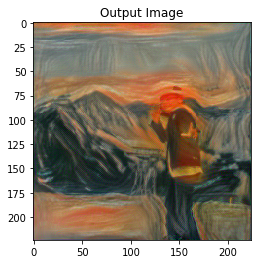

In [53]:
imshow(output, "/content/drive/My Drive/DeepLearningX/sample/output/test.jpg", title='Output Image')

# sphinx_gallery_thumbnail_number = 4

plt.ioff()
plt.show()

# Neural Transfer on segmented image

In [0]:
## Background: Image object
## img: Image object
## rgb: array object
def pastePictures(background, img, rgb):

  image = img.cpu().clone()  # we clone the tensor to not do changes on it
  image = image.squeeze(0)      # remove the fake batch dimension
  image = unloader(image)
  image = np.array(image)
  print(image.shape)

  background = background.cpu().clone()  # we clone the tensor to not do changes on it
  background = background.squeeze(0)      # remove the fake batch dimension
  background = unloader(background)
  background = np.array(background)
  print(background.shape)
  print(rgb.shape)
  # target_size = (img_.shape[1],img_.shape[0])
  # background = background.resize(target_size)

  #background[rgb != 0] = image[ rgb != 0]
  
  for i in range(0,image.shape[0]):
    for j in range(0,image.shape[1]):
      for a in range(0, image.shape[2]):
        if rgb[i][j][a] != 0:
          background[i][j][a] = image[i][j][a]
  

  return Image.fromarray(background), background, image

In [65]:
paste, background, image = pastePictures(output, content_img, rgb)

plt.figure(figsize=(10,10))
plt.imshow(background)

(224, 224, 3)
(224, 224, 3)
(720, 960, 3)


IndexError: ignored